In [9]:
include("/Users/meesvandartel/Desktop/Coursework/CGT/DeepEWA/ProbsEWA.jl")
using Flux, .pEWA, Random, IterTools, ProgressMeter, DataFrames, CSV, Statistics

#### Attraction updating function:
$$
Q_{i}^{\mu}(t) = \frac{(1-\alpha) N(t-1) Q_{i}^{\mu}(t-1)}{N(t)} + \frac{\left[ \delta + (1-\delta) \mathbb{I}(s_i^\mu,s^{-\mu}(t)) \right] \Pi^\mu(s_i^\mu, s^{-\mu}(t))}{N(t)}
$$

#### Mixed strategy determination:
$$
\sigma^{\mu}(t)=\frac{e^{\beta Q_1^R (t)}}{e^{\beta Q_1^R (t)} + e^{\beta Q_2^R (t)}}
$$


#### Special Cases:
$$ 
\begin{aligned}
&\text{best response dynamics:  }\alpha=1, \quad \beta = +\infty, \quad \delta = 1, \quad \forall \kappa \in [0,1] \\
&\text{reinforcement learning:  }\delta = 0, \quad \forall \kappa \in [0,1] \\
&\quad\text{average RL: } \quad \kappa=0, \quad \text{cummulative RL: } \quad \kappa = 1 \\
&\text{ficticious play:  }\alpha=0, \quad \beta = +\infty, \quad \delta = 1, \quad  \kappa = 0\\
&\quad\text{stochastic ficticious play:  } \beta < +\infty\\
&\text{replicator dynamics:  } \beta \rightarrow 0, \quad \alpha = 0, \quad \delta = 1, \quad \forall \kappa \in (0,1]\\
&\text{logit dynamics:  } \alpha = 1, \quad \delta = 1,\quad \kappa = 1
\end{aligned}
$$ 

In [10]:
# this data will be for this specific coordination game with 2 NE and 1 mixed NE.
coord = [[[5 1; 1 4], [5 1; 1 4]], pEWA.find_NE_mixed([[5 1; 1 4], [5 1; 1 4]])]
dom = [[[5 0; 20 1], [5 0; 20 1]], pEWA.find_NE_mixed([[5 0; 20 1], [5 0; 20 1]])]
cyclic = [[[5 1;1 4],[-5 1; 1 -4]], pEWA.find_NE_mixed([[5 1;1 4],[-5 1; 1 -4]])]

# set game and amount of observations
game = coord
points = 20000

20000

In [11]:
# generating data

α_grid, κ_grid, δ_grid = [rand(0.0:0.0001:1.0, points) for _ in 1:3]
β_grid = exp.(rand(0.0:0.001:1.5, points)) # take exp to get the lim to infty effect since β is unbounded above
combs = [[α_grid[i], κ_grid[i], δ_grid[i], β_grid[i]] for i in 1:points]

#testing
#combs = [[α_grid[i], 0.0, 1.0, β_grid[i]] for i in 1:points]

subset=Int64(floor(0.6*length(combs))) #60/40 train test split
x_train, x_test = combs[1:subset], combs[(subset+1):end]
y_train, y_test = Vector{Int64}(undef, length(x_train)),Vector{Int64}(undef, length(x_test))

# should take about 6min for 1mil obs
@showprogress for i in 1:length(x_train)
    comb=x_train[i]
    α, κ, δ, β = comb
    params = pEWA.init_pEWA(;α=α, κ=κ, δ=δ, β=β,game=game)
    cat = pEWA.multicat_pEWA(params)
    y_train[i] = cat
end

@showprogress for i in 1:length(x_test)
    comb = x_test[i]
    α, κ, δ, β = comb
    params = pEWA.init_pEWA(;α=α, κ=κ, δ=δ, β=β,game=game)
    cat = pEWA.multicat_pEWA(params)
    y_test[i] = cat
end

x_train = hcat([Float32.(x[1:4]) for x in x_train]...)
x_test = hcat([Float32.(x[1:4]) for x in x_test]...)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


done

In [12]:
deepEWA= Chain(
    Dense(4 => 32, relu),
    Dense(32 => 32, relu),
    Dense(32 => 32, relu),
    Dense(32 => 4)
    )

target = Flux.onehotbatch(y_train, 1:4)   
loader = Flux.DataLoader((x_train, target), batchsize=64, shuffle=true);
opt = Flux.setup(Flux.AdaGrad(), deepEWA)

losses=[]
@showprogress for epoch in 1:2000
    for xy in loader
        x,y = xy
        loss, grads = Flux.withgradient(deepEWA) do m
            y_hat = m(x)
            Flux.logitcrossentropy(y_hat, y)
        end
        Flux.update!(opt, deepEWA, grads[1])
        push!(losses, loss)
    end
end

out2 = deepEWA(x_test)
probs2 = softmax(out2)
predicted_labels = Flux.onecold(probs2, 1:4)
print("done")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


done

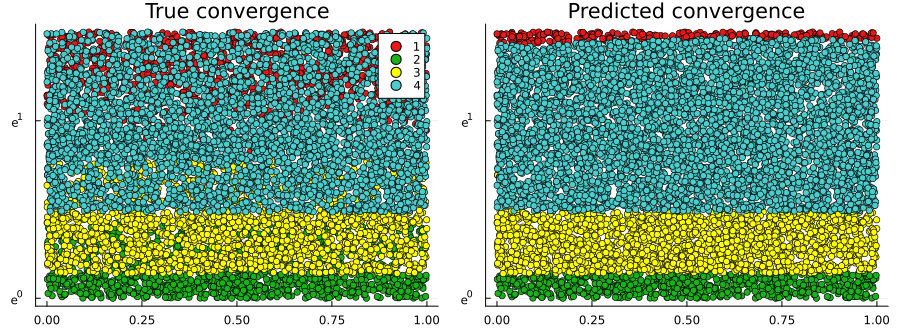

In [15]:
using Plots
custom_palette = [RGB(0.9, 0.1, 0.1), RGB(0.1, 0.7, 0.1), RGB(1.0, 1.0, 0.0), RGB(0.3, 0.8, 0.8)]

p_true = scatter(x_test[1,:], x_test[4,:], group=y_test, title="True convergence", legend=true,
markersize=3.5, palette=custom_palette, yscale=:ln)
p_done = scatter(x_test[1,:], x_test[4,:], group=predicted_labels, title="Predicted convergence", legend=false,
markersize=3.5, palette=custom_palette, yscale=:ln)

plot(p_true, p_done, layout=(1,2), size=(900,330))
# 1 = cycles/chaos, 2 = mixed FP, 3 = pure FP, 4= pure NE

# e^0 = 1 so also include values between 0 and 1

In [14]:
accuracy = mean(predicted_labels .== y_test)

0.7375